In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv


# 0 import packages

In [2]:
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, Flatten, add
from keras.layers import Conv2D, Activation, MaxPooling2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing. image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, PReLU, Dropout
from keras.models import Model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD, Adam, RMSprop
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import seaborn as sns
sns.set()
%matplotlib inline

Using TensorFlow backend.


# 1 加载训练集和测试集

In [3]:
%%time
train_data = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test_data = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

CPU times: user 4.9 s, sys: 528 ms, total: 5.43 s
Wall time: 5.46 s


# 2 查看label分布情况

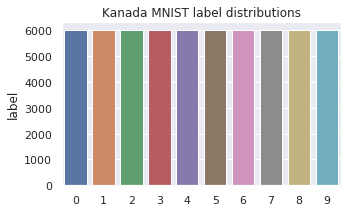

In [4]:
label_values=train_data['label'].value_counts().sort_index()
plt.figure(figsize=(5,3))
plt.title("Kanada MNIST label distributions")
sns.barplot(x=label_values.index, y=label_values)

# 3 将csv数据转换成图像

In [5]:
img_train = train_data.drop(["label"], axis=1).values.reshape(-1, 28, 28, 1).astype('float32')
img_label = train_data["label"]
img_test = test_data.drop(["id"], axis=1).values.reshape(-1, 28, 28, 1).astype('float32')
print("img_train.shape = ", img_train.shape)
print("img_label.shape = ", img_label.shape)
print("img_test.shape = ", img_test.shape)

img_train.shape =  (60000, 28, 28, 1)
img_label.shape =  (60000,)
img_test.shape =  (5000, 28, 28, 1)


### 3.1 查看一下样本图片及其对应的label

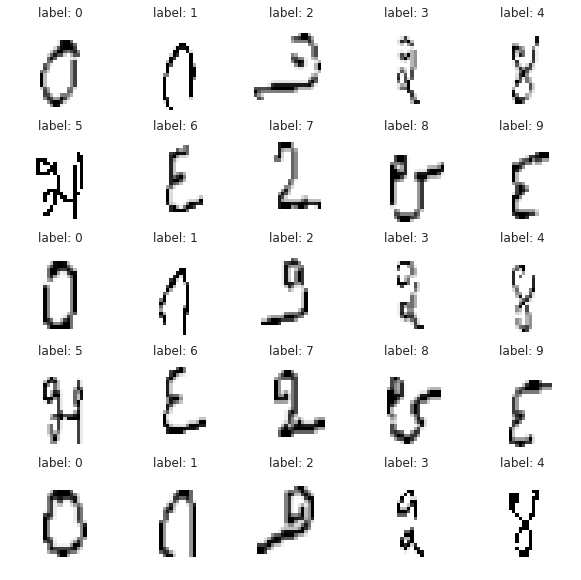

In [6]:
fig = plt.figure(figsize=(10, 10))
show_img = 0
for idx in range(img_train.shape[0]):
    plt.subplot(5, 5, show_img + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_train[idx].reshape(28, 28), cmap=plt.cm.binary)
    plt.title("label: %d" % img_label[idx])
    show_img += 1
    if show_img % 25 == 0:
        break

# 4 构建模型

### 4.1 搭建了一个卷积神经网络

In [7]:
def build_model(input_shape=(28, 28, 1), num_classes = 10):
    input_layer = Input(shape=input_shape)
    # 第一个卷积层，32个卷积核，大小5x5，卷积模式SAME,激活函数prelu
    x = Conv2D(filters=32, kernel_size=(5, 5), padding="same", name="conv1")(input_layer)
    x = PReLU()(x)
    # 第二个卷积层，32个卷积核，大小5x5，卷积模式SAME,激活函数prelu
    x = Conv2D(filters=32, kernel_size=(5, 5), padding="same", name="conv2")(x)
    x = PReLU()(x)
    # 第一层池化层，池化核大小2x2
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 随机丢弃四分之一的网络连接，防止过拟合
    x = Dropout(0.25)(x)
    # 第三个卷积层，64个卷积核，大小3x3，卷积模式SAME,激活函数prelu
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", name="conv3")(x)
    # 第四个卷积层，64个卷积核，大小3x3，卷积模式SAME,激活函数prelu
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", name="conv4")(x)
    # 第二层池化层，池化核大小2x2
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 随机丢弃四分之一的网络连接，防止过拟合
    x = Dropout(0.25)(x)
    # 第五个卷积层，128个卷积核，大小3x3，卷积模式SAME,激活函数prelu
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", name="conv5")(x)
    # 第六个卷积层，128个卷积核，大小3x3，卷积模式SAME,激活函数prelu
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", name="conv6")(x)
    # 第三层池化层，池化核大小2x2
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 随机丢弃四分之一的网络连接，防止过拟合
    x = Dropout(0.25)(x)
    # 全连接层,展开操作
    x = Flatten()(x)
    # 添加隐藏层神经元的数量和激活函数
    x = Dense(512, name="full1")(x)
    x = PReLU()(x)
    x = Dense(256, name="full2")(x)
    x = PReLU()(x)
    # 输出层
    x = Dense(num_classes, activation='softmax', name="output")(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

### 4.2 查看一下模型结构

In [8]:
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 28, 28, 32)        25088     
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        25632     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 28, 28, 32)        25088     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0   

# 5 划分训练集和验证集

In [9]:
from sklearn.model_selection import train_test_split
X_data = img_train / 255
Y_data = to_categorical(img_label)
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.1)
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

x_train.shape =  (54000, 28, 28, 1)
y_train.shape =  (54000, 10)
x_test.shape =  (6000, 28, 28, 1)
y_test.shape =  (6000, 10)


# 6 数据增强

数据增强的作用通常是为了扩充训练数据量提高模型的泛化能力，同时通过增加了噪声数据提升模型的鲁棒性。这里采用了比较简单的数据增强方法包括旋转、平移

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=9, 
    zoom_range=0.25, 
    width_shift_range=0.25, 
    height_shift_range=0.25
)
train_datagen.fit(x_train)
sgd = SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
rms = RMSprop(lr=0.1)
adam = Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
checkpoint = ModelCheckpoint("bestmodel.model", monitor='val_accuracy', verbose=1, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='min')

In [11]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# 7 训练模型

### 7.1 设置训练批次和batch_size

In [12]:
epochs = 120
batch_size = 128

### 7.2 训练模型

In [13]:
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, learning_rate_reduction])

Epoch 1/120
421/421 [==============================] - 17s 40ms/step - loss: 1.2944 - accuracy: 0.5381 - val_loss: 0.2527 - val_accuracy: 0.9058

Epoch 00001: val_accuracy improved from -inf to 0.90583, saving model to bestmodel.model
Epoch 2/120
421/421 [==============================] - 15s 36ms/step - loss: 0.2902 - accuracy: 0.9022 - val_loss: 0.3030 - val_accuracy: 0.9097

Epoch 00002: val_accuracy improved from 0.90583 to 0.90967, saving model to bestmodel.model
Epoch 3/120
421/421 [==============================] - 15s 36ms/step - loss: 0.1795 - accuracy: 0.9391 - val_loss: 0.0450 - val_accuracy: 0.9848

Epoch 00003: val_accuracy improved from 0.90967 to 0.98483, saving model to bestmodel.model
Epoch 4/120
421/421 [==============================] - 15s 36ms/step - loss: 0.1385 - accuracy: 0.9548 - val_loss: 0.0386 - val_accuracy: 0.9875

Epoch 00004: val_accuracy improved from 0.98483 to 0.98750, saving model to bestmodel.model
Epoch 5/120
421/421 [==============================

### 7.3 绘制loss曲线和accuracy曲线

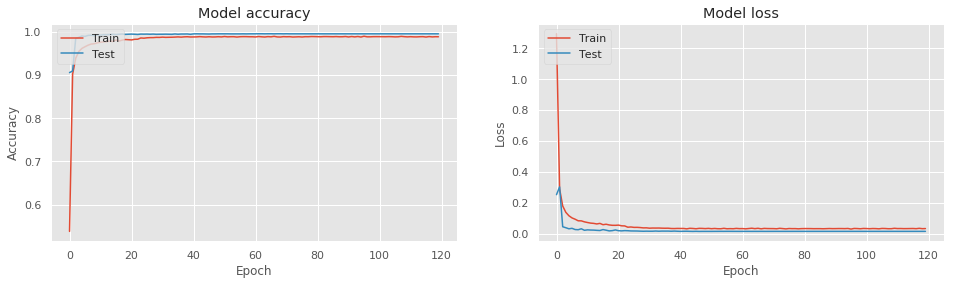

In [14]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 8 Test预估

In [15]:
results=model.predict(img_test/255.0)
results=np.argmax(results, axis=1)

### 8.1 test预估值展示

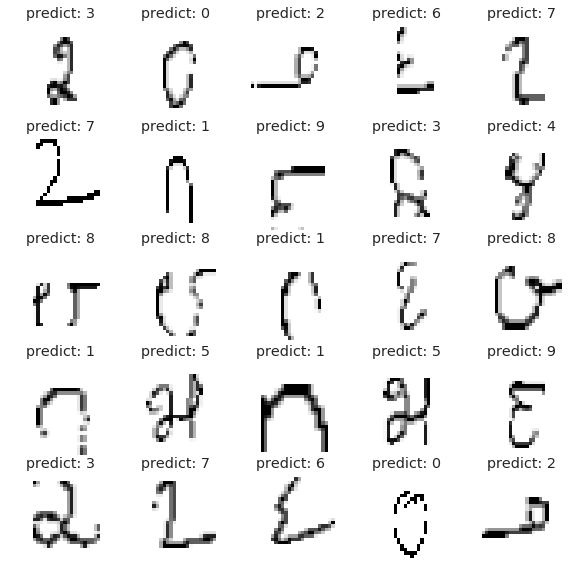

In [16]:
fig = plt.figure(figsize=(10, 10))
show_img = 0
for idx in range(img_test.shape[0]):
    plt.subplot(5, 5, show_img + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_test[idx].reshape(28, 28), cmap=plt.cm.binary)
    plt.title("predict: %d" % results[idx])
    show_img += 1
    if show_img % 25 == 0:
        break

### 8.2 提交文件

In [17]:
sub=pd.DataFrame()
sub['id']=list(test_data.values[0:,0])
sub['label']=results
sub.to_csv("submission.csv", index=False)